In [47]:
# importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.inspection import permutation_importance
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored,cumulative_dynamic_auc, integrated_brier_score
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif





In [8]:
# load processed dataframes
metadata_df = pd.read_csv('../data/cancer_metadata.csv', index_col=0)
expression = pd.read_csv('../data/cancer_only_hvg.csv', index_col=0)

In [ ]:
# train test split
metadata_df = metadata_df.drop(['age'], axis=1)
final_df = metadata_df.merge(expression, left_index=True,right_index=True)

In [ ]:
# splitting X and y and preparing right format for scikit survival 
y = final_df[['os_status','os_time']]
y = np.array(
    list(zip(
        y['os_status'].astype(bool),
        y['os_time']
    )),
    dtype=[('os_status', '?'), ('os_time', '<f8')]
)

X = final_df.drop(columns=['os_status', 'os_time'])

In [11]:
# splitting train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y['os_status']
)

In [12]:
# custom wrapper function for survival model tuning
def c_index_scorer(estimator, X,y):
    surv_pred = estimator.predict(X)
    result = concordance_index_censored(y['os_status'], y['os_time'], surv_pred)
    return result[0]
# define the random forest model
rsf = RandomSurvivalForest(random_state=42)

# 4. Define the parameter distribution
param_dist = {
    "n_estimators": [100,200,300,500],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2,3,5,7],
    "min_samples_leaf": [2,3,5],
    "max_features": ["sqrt", "log2",  None]
}

# 5. Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rsf,
    param_distributions=param_dist,
    cv=5,
    scoring=c_index_scorer, 
    random_state=42,
)

# 6. Fit the model
random_search.fit(X_train, y_train)

# 7. View best params
print("Best Parameters:", random_search.best_params_)
print("Best C-index on training data:", random_search.best_score_)

# 8. Use the best model
best_rsf = random_search.best_estimator_
rsf_predict = best_rsf.predict(X_test)

Best Parameters: {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 3}
Best C-index on training data: 0.5496572733324806


In [22]:
os.makedirs("../results/cancer_survival", exist_ok=True)
# %% AUC Plotting
def plot_auc(model_name, y_train, y_test, preds, intervals):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, preds, intervals)
    plt.figure()
    plt.plot(intervals, auc, marker="o", label=f"{model_name} (mean AUC = {mean_auc:.3f})")
    plt.axhline(mean_auc, linestyle="--", color='gray')
    plt.xlabel("Days from enrollment")
    plt.ylabel("Time-dependent AUC")
    plt.title(f"{model_name} - Time-dependent AUC")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../results/cancer_survival/{model_name}_auc_plot.png")
    plt.show()
    plt.close()
    return auc, mean_auc

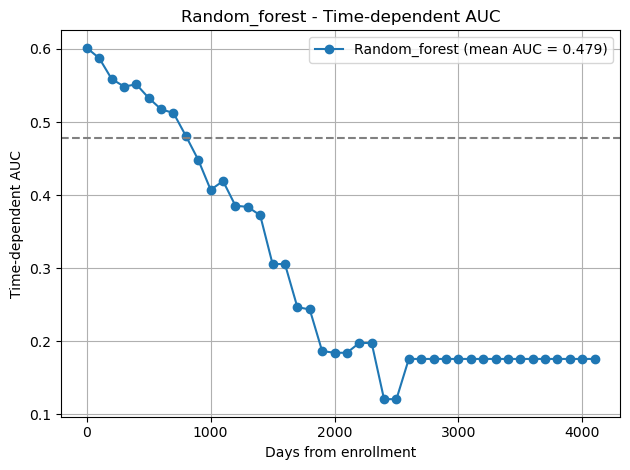

(array([0.60144058, 0.58747447, 0.55915916, 0.54861111, 0.55155211,
        0.53289474, 0.51751071, 0.51233155, 0.48101266, 0.44827586,
        0.40729167, 0.41932002, 0.38558559, 0.38393465, 0.37241379,
        0.30579297, 0.30579297, 0.24682203, 0.24369748, 0.18677686,
        0.18442623, 0.18442623, 0.19783198, 0.19783198, 0.12096774,
        0.12096774, 0.176     , 0.176     , 0.176     , 0.176     ,
        0.176     , 0.176     , 0.176     , 0.176     , 0.176     ,
        0.176     , 0.176     , 0.176     , 0.176     , 0.176     ,
        0.176     , 0.176     ]),
 0.47871424819223346)

In [23]:
# plotting auc
y_min,y_max = np.min(y_test['os_time']), np.max(y_test['os_time'])
intervals = np.arange(y_min,y_max,100)
plot_auc("Random_forest",y_train,y_test,rsf_predict,intervals)

In [ ]:
# selecting 30 best features
bestk = SelectKBest(score_func=f_classif, k=30)
bestk.fit(X_train, y_train)
X_train_selected = bestk.transform(X_train)
X_test_selected = bestk.transform(X_test)
selected_feature_names = X_train.columns[bestk.get_support()]

# Re-wrap into DataFrames for easier plotting and model interpretation
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_feature_names, index=X_train.index)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_feature_names, index=X_test.index)



In [52]:
# define the random forest model
rsf = RandomSurvivalForest(random_state=42)

# 4. Define the parameter distribution
param_dist = {
    "n_estimators": [100,200,300,500],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2,3,5,7],
    "min_samples_leaf": [2,3,5],
    "max_features": ["sqrt", "log2",  None]
}

# 5. Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rsf,
    param_distributions=param_dist,
    cv=5,
    scoring=c_index_scorer, 
    random_state=42,
)

# 6. Fit the model
random_search.fit(X_train_selected, y_train)

# 7. View best params
print("Best Parameters:", random_search.best_params_)
print("Best C-index on training data:", random_search.best_score_)

# 8. Use the best model
best_rsf = random_search.best_estimator_
rsf_predict = best_rsf.predict(X_test_selected)

Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
Best C-index on training data: 0.5121213367601554


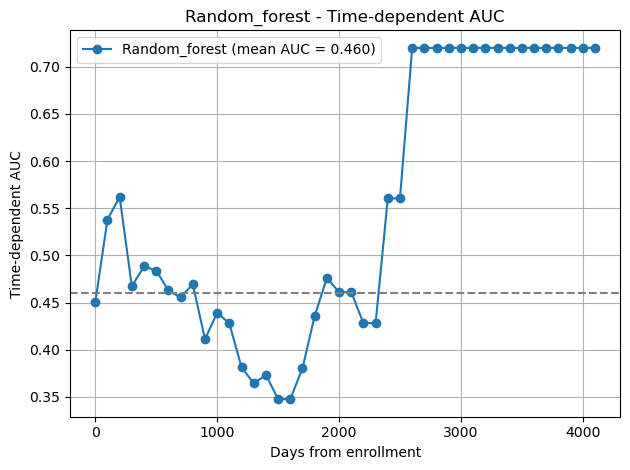

(array([0.45018007, 0.5377808 , 0.56216216, 0.46732026, 0.4883592 ,
        0.48394737, 0.46283699, 0.45537757, 0.46970105, 0.41114058,
        0.43923611, 0.42795467, 0.38138138, 0.36419333, 0.37327586,
        0.34757835, 0.34757835, 0.38029661, 0.43577431, 0.47603306,
        0.46106557, 0.46106557, 0.42818428, 0.42818428, 0.56048387,
        0.56048387, 0.72      , 0.72      , 0.72      , 0.72      ,
        0.72      , 0.72      , 0.72      , 0.72      , 0.72      ,
        0.72      , 0.72      , 0.72      , 0.72      , 0.72      ,
        0.72      , 0.72      ]),
 0.4602181079477228)

In [53]:
# plotting auc
y_min,y_max = np.min(y_test['os_time']), np.max(y_test['os_time'])
intervals = np.arange(y_min,y_max,100)
plot_auc("Random_forest",y_train,y_test,rsf_predict,intervals)

In [54]:
# define the gradient boosting forest model
gbs = GradientBoostingSurvivalAnalysis(random_state=42)

# Define the parameter distribution
param_dist = {
    "n_estimators": [100,200,300,500],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2,3,5,7],
    "min_samples_leaf": [2,3,5],
    "learning_rate" : [0.01,0.1]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    gbs,
    param_distributions=param_dist,
    cv=5,
    scoring=c_index_scorer, 
    random_state=42,
)

# Fit the model
random_search.fit(X_train_selected, y_train)

# View best params
print("Best Parameters:", random_search.best_params_)
print("Best C-index on training data:", random_search.best_score_)

# Use the best model
best_gbs = random_search.best_estimator_
gbs_predict = best_gbs.predict(X_test_selected)

Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 10, 'learning_rate': 0.01}
Best C-index on training data: 0.5089256457347573


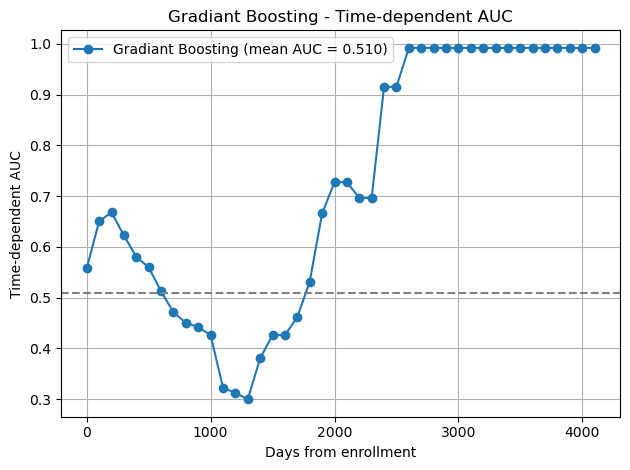

(array([0.55822329, 0.65078285, 0.66786787, 0.62254902, 0.58037694,
        0.55973684, 0.51247166, 0.47114162, 0.45057905, 0.44208665,
        0.42604167, 0.32271991, 0.31231231, 0.30020422, 0.38103448,
        0.42640076, 0.42640076, 0.46186441, 0.53181273, 0.6661157 ,
        0.72745902, 0.72745902, 0.69647696, 0.69647696, 0.91532258,
        0.91532258, 0.992     , 0.992     , 0.992     , 0.992     ,
        0.992     , 0.992     , 0.992     , 0.992     , 0.992     ,
        0.992     , 0.992     , 0.992     , 0.992     , 0.992     ,
        0.992     , 0.992     ]),
 0.5098384002042375)

In [55]:
# plot AUC
plot_auc('Gradiant Boosting',y_train,y_test,gbs_predict,intervals)

In [56]:
# model evaluation with c index and brier score

rsf_surv_prob = np.vstack([fn(intervals) for fn in best_rsf.predict_survival_function(X_test_selected)])
gbs_surv_prob = np.vstack([fn(intervals) for fn in best_gbs.predict_survival_function(X_test_selected)])

score_cindex = pd.Series(
    [
        best_rsf.score(X_test_selected, y_test),
        best_gbs.score(X_test_selected, y_test),
    ],
    index=["RSF", "GBS"],
    name="c-index",
)
score_brier = pd.Series(
    [
        integrated_brier_score(y_train, y_test, prob, intervals)
        for prob in (rsf_surv_prob, gbs_surv_prob)
    ],
    index=["RSF", "GBS"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)


,c-index,IBS
RSF,0.472,0.074
GBS,0.506,0.079


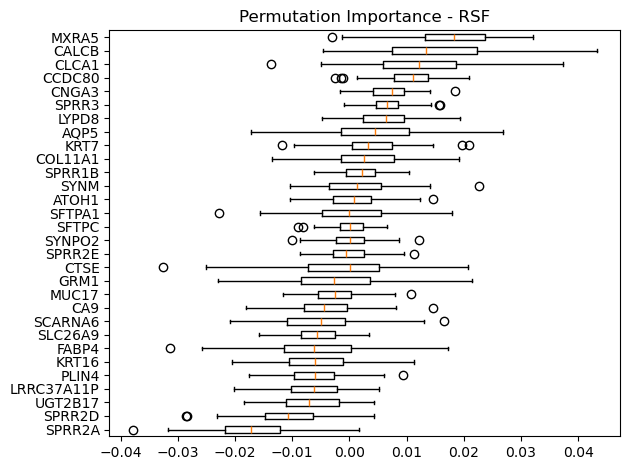

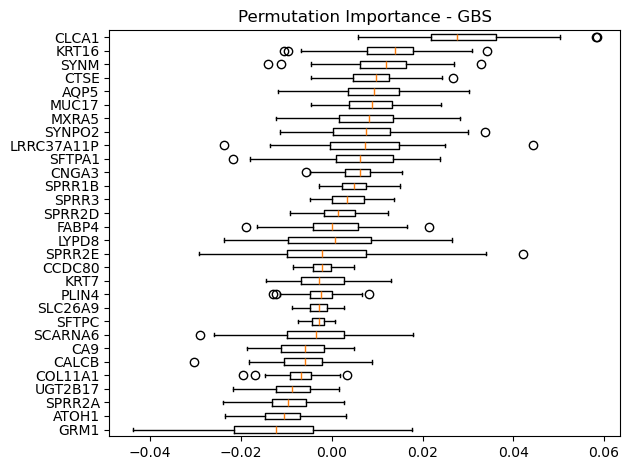

In [57]:
def plot_permutation_importance(model, X_test, y_test, model_name='Model', n_repeats=100, random_state=42):
    """
    Computes and plots permutation importance for a fitted model.

    Parameters:
    - model: Fitted model (e.g., RandomSurvivalForest or GradientBoostingSurvivalAnalysis)
    - X_test: Test features (DataFrame)
    - y_test: Test target
    - model_name: Name to display in plot title
    - n_repeats: Number of permutations (default=100)
    - random_state: Random seed for reproducibility
    """
    result = permutation_importance(model, X_test, y_test, n_repeats=n_repeats, random_state=random_state)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title(f'Permutation Importance - {model_name}')
    fig.tight_layout()
    plt.show()
    

plot_permutation_importance(best_rsf, X_test_selected, y_test, model_name='RSF')
plot_permutation_importance(best_gbs, X_test_selected, y_test, model_name='GBS')


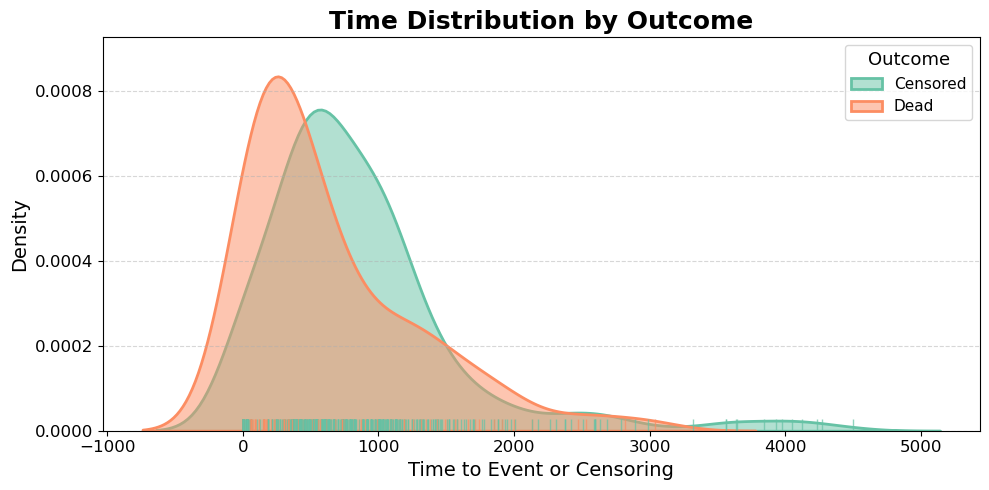

In [58]:
import sys
sys.path.append('../scripts')  

from plotting_utils import plot_time_distribution_by_outcome

plot_time_distribution_by_outcome(metadata_df, time_col='os_time', status_col='os_status')